#**American Final Grade Predictor**

We collected data from almost 700 students from two portuguese high schools to predict grades.

Portuguese students are given a grade from 0 to 20. This scaling can be translated into the American grading system from A-F

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import r2_score, f1_score, confusion_matrix, classification_report, accuracy_score, mean_squared_error

from sklearn.model_selection import cross_validate, cross_val_score

In [2]:
from google.colab import files

uploaded = files.upload() #comment out this line after uploading file
df = pd.read_csv('student-por.csv')
df.head()

Saving student-por.csv to student-por.csv


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [ ]:
print(df.shape) #(649, 33)

print(df.columns)

#no null values
print(df.isnull().any())

In [ ]:
#descriptive statustics
print(df.describe())

In [ ]:
#Bar plots of three grade periods
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
sns.countplot(df["G1"], x="final grade")
plt.subplot(1,3,2)
sns.countplot(df["G2"], x="final grade")
plt.subplot(1,3,3)
sns.countplot(df["G3"], x="final grade")
plt.show()

In [3]:
#creating average grades with G1 and G2
df["current"] = round((df["G1"]+df["G2"])/2,2)
df=df.drop(["G1","G2"], axis=1)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,current
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,11,5.5
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,11,10.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,12.5
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,13,12.0


In [ ]:
sns.distplot(df["G3"], bins=25)
plt.xlabel("Average Grade")

In [ ]:
#Male and Female grade differences
male = df.query("sex=='M'")
female = df.query("sex=='F'")

male.shape #(266, 33)
female.shape #(383, 33)

plt.figure(figsize=(8,6))
sns.kdeplot(data=male["G3"], color="blue", label="Male grades", shade=True)
sns.kdeplot(data=female["G3"], color="pink", label="Female grades", shade=True)

plt.title("Histogram of grades, by Sex")

plt.legend()
plt.show()

#Males and Females seem to have a similar grade distribution. This feature might have a slight effect.

In [ ]:
#is there a relationship between number of failed classes and final grade?
plt.figure(figsize=(10,6))

sns.boxplot(x="failures", y="G3", hue="sex",data=df)

plt.xlabel("Number of classes failed")
plt.ylabel("final grade")
plt.show()

#students with no failed classes have a higher median and maximum than those who have failed a class.

In [ ]:
#Check the grades for each binary feature
boxplots = ['address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

plt.figure(figsize=(17,17))

for index, item in enumerate(boxplots):
  plt.subplot(4,3,index+1)
  sns.boxplot(x=item, y="G3", data=df)
  plt.ylabel("average grade (0-20)") 
  plt.title(item+" vs Average Grades")

plt.subplots_adjust(bottom=1, top = 2)

plt.show()
#There seems to be very little differences

In [4]:
bins = (-1,7.5,10,12.5,15,20)
grade_names = ("F","D","C","B","A")
df["American"] = pd.cut(df["G3"], bins = bins, labels = grade_names)
df["American"].unique()

['C', 'B', 'A', 'F', 'D']
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

In [ ]:
#percentages of grades
(df["American"].value_counts().sort_index(ascending=False)/df.shape[0])*100

A    12.634823
B    29.892142
C    27.118644
D    25.731895
F     4.622496
Name: American, dtype: float64

In [ ]:
df["American"].value_counts().sort_index(ascending=False)

A     82
B    194
C    176
D    167
F     30
Name: American, dtype: int64

In [ ]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,current,American
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,11,5.5,C
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,11,10.0,C
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,12.5,C
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14.0,B
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,13,12.0,B


In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sns.countplot(x=df["American"], hue=df["reason"])

In [ ]:
#Mothers' and Fathers' jobs
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sns.countplot(x=df["Mjob"], hue=df["American"])
plt.subplot(2,1,2)
sns.countplot(x=df["Fjob"], hue=df["American"])
plt.show()

In [ ]:
plt.figure(figsize=(10,20))

plt.subplot(2,1,1)
sns.boxplot(x="Mjob", y = "G3", data = df)
plt.subplot(2,1,2)
sns.boxplot(x="Fjob", y = "G3", data = df)
plt.show()

In [ ]:
#One Hot Encode Mother Job
df = pd.concat([df, pd.get_dummies(df["Mjob"],prefix="Mjob")], axis=1)

In [ ]:
df = df.drop(["Mjob", "Mjob_teacher"], axis=1)

In [ ]:
#One Hot Encode Father Job
df = pd.concat([df, pd.get_dummies(df["Fjob"],prefix="Fjob")], axis=1)
df = df.drop(["Fjob", "Fjob_teacher"], axis=1)

In [ ]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,current,American,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services
0,GP,1,18,1,1,0,4,4,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,11,5.5,2,1,0,0,0,0,0,0,0
1,GP,1,17,1,1,1,1,1,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,11,10.0,2,1,0,0,0,0,0,1,0
2,GP,1,15,1,0,1,1,1,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,12.5,2,1,0,0,0,0,0,1,0
3,GP,1,15,1,1,1,4,2,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14.0,1,0,1,0,0,0,0,0,1
4,GP,1,16,1,1,1,3,3,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,13,12.0,1,0,0,1,0,0,0,1,0


In [5]:
#Binarize columns
encoded_columns=['schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']


for column in encoded_columns:
  df[column] = [1 if value == "yes" else 0 for value in df[column]]

df['address'] = df['address'].map({"R": 0, "U":1})
df['famsize'] = df['famsize'].map({"LE3": 0, "GT3":1})
df['Pstatus'] = df['Pstatus'].map({"A": 0, "T":1})
df['sex'] = df['sex'].map({'M':0,'F':1})

In [ ]:
df.head(10)

In [ ]:
#correlations and visualization
corr = df.drop('American', axis=1).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)
plt.show()
# Some correlation with address, Mother and father education, study time, higher education, access to internet, and family relationships

In [6]:
#Label encode American grades
le = LabelEncoder()
df["American"] = le.fit_transform(df["American"])

In [7]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,current,American
0,GP,1,18,1,1,0,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,11,5.5,2
1,GP,1,17,1,1,1,1,1,at_home,other,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,11,10.0,2
2,GP,1,15,1,0,1,1,1,at_home,other,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,12.5,2
3,GP,1,15,1,1,1,4,2,health,services,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14.0,1
4,GP,1,16,1,1,1,3,3,other,other,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,13,12.0,1


##**Regression**

In [6]:
#seperate data into response and feature variables. (regression)
X = df[["sex",'address', 'Medu',"Fedu", "studytime","failures", "higher", "internet", "activities", "famrel","absences","current"]]
y = df["G3"]


#"Mjob_at_home","Mjob_health", "Mjob_other","Mjob_services","Fjob_at_home","Fjob_health","Fjob_other","Fjob_services"


In [10]:
#train-test split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=30)

transfer = StandardScaler()
X_train = transfer.fit_transform(X_train)
X_test = transfer.transform(X_test)

In [ ]:
#Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#cross validate
lm_cv = cross_validate(lin_reg, X_train, y_train, cv = 5, return_train_score=True, scoring=("r2","neg_mean_squared_error"))
print("r2 train accuracies:", lm_cv['train_r2'].mean(), "\nMRE train accuracies:", lm_cv['train_neg_mean_squared_error'].mean())
print("r2 test accuracies:", lm_cv['test_r2'].mean(), "\nMRE test accuracies:", lm_cv['test_neg_mean_squared_error'].mean())

r2 train accuracies: 0.8226164679587343 
MRE train accuracies: -1.8765748579713517
r2 test accuracies: 0.8003925227726022 
MRE test accuracies: -2.06970157592922


In [ ]:
#Polynomial fit
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
new_reg = LinearRegression()
new_reg.fit(X_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#cross validate poly
import math
poly_cv = cross_validate(new_reg, X_poly, y_train, cv = 5, return_train_score=True, scoring=("r2","neg_mean_squared_error"))
print("r2 train accuracies:", poly_cv['train_r2'].mean(), "\nMRE train accuracies:", math.sqrt(-poly_cv['train_neg_mean_squared_error'].mean()))
print("r2 test accuracies:", poly_cv['test_r2'].mean(), "\nMRE test accuracies:", math.sqrt(-poly_cv['test_neg_mean_squared_error'].mean()))

r2 train accuracies: 0.870085540010655 
MRE train accuracies: 1.17096140815098
r2 test accuracies: 0.7121954806521879 
MRE test accuracies: 1.6967298317818158


In [ ]:
# Liner regression predictions
lin_pred = lin_reg.predict(X_test)

X_poly_test = poly_reg.fit_transform(X_test)
poly_pred = new_reg.predict(X_poly_test)

In [ ]:
print("r2_score for linear:", r2_score(y_test,lin_pred), mean_squared_error(y_test,lin_pred))
print("r2_score for polynomial of degree 2:", r2_score(y_test,poly_pred),mean_squared_error(y_test,poly_pred))

r2_score for linear: 0.8266871975977764 1.674560603044774
r2_score for polynomial of degree 2: 0.7430370891507198 2.4827938905129066


##**Classification**

In [ ]:
#seperate data into response and feature variables. (classification)
X = df[["sex",'Medu',"Fedu", "studytime","failures","internet", "higher", "activities", "schoolsup","current"]]
y = df["American"]

In [ ]:
#Train-test split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 30)

### K Nearest Neighbors

In [ ]:
knn_real = KNeighborsClassifier(n_neighbors=11)
knn_real.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [ ]:
knn_real_cv = cross_validate(knn_real,  X_train, y_train, cv = 10, return_train_score = True, scoring = "accuracy")
print("Training accuracies:", knn_real_cv['train_score'].mean(), "\nTest accuracies:", knn_real_cv['test_score'].mean())

Training accuracies: 0.7332496019326855 
Test accuracies: 0.7034313725490196


In [ ]:
k_range = range(1,41)
k_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_validate(knn,  X_train, y_train, cv = 10, return_train_score = True, scoring = "accuracy")
  k_scores.append(scores["test_score"].mean())

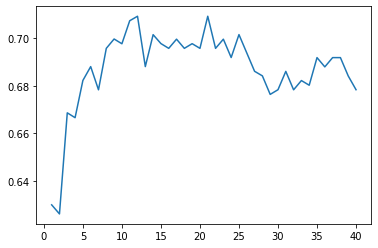

In [ ]:
sns.lineplot(x = k_range, y = k_scores) #11 n_neighbors remains the best

In [ ]:
knn_pred = knn_real.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))
print(accuracy_score(y_test,knn_pred))

[[19  2  0  0  0]
 [ 1 31  8  0  0]
 [ 0  7 25  5  0]
 [ 0  0 10 17  1]
 [ 0  0  0  2  2]]
              precision    recall  f1-score   support

           A       0.95      0.90      0.93        21
           B       0.78      0.78      0.78        40
           C       0.58      0.68      0.63        37
           D       0.71      0.61      0.65        28
           F       0.67      0.50      0.57         4

    accuracy                           0.72       130
   macro avg       0.74      0.69      0.71       130
weighted avg       0.73      0.72      0.72       130

0.7230769230769231


### Random Forest Classifier

In [7]:
X = df[["activities",'current',"Fedu", "higher","internet", "Medu", "schoolsup", "sex","studytime"]]
y = df["American"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 30)

In [8]:
rf_clf = RandomForestClassifier(n_estimators = 400,max_depth = 6,random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [9]:
rf_cv = cross_validate(rf_clf,  X_train, y_train, cv = 5, return_train_score = True, scoring = "accuracy")
print("Training accuracies:", rf_cv['train_score'].mean(), "\nValidation accuracies:", rf_cv['test_score'].mean())

Training accuracies: 0.8285206209453199 
Validation accuracies: 0.7148805078416729


In [ ]:
#feature importance
print(list(X_train.columns), "\nimportances", rf_clf.feature_importances_)

['sex', 'Medu', 'Fedu', 'studytime', 'internet', 'higher', 'activities', 'schoolsup', 'current'] 
importances [0.02210837 0.05758839 0.05032995 0.0493957  0.0228207  0.03345522
 0.02835322 0.02002005 0.71592841]


In [10]:
rf_pred = rf_clf.predict(X_test)
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))
print(accuracy_score(y_test,rf_pred))

[[17  4  0  0  0]
 [ 0 34  6  0  0]
 [ 0  7 22  8  0]
 [ 0  0  4 23  1]
 [ 0  0  0  3  1]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.76      0.85      0.80        40
           2       0.69      0.59      0.64        37
           3       0.68      0.82      0.74        28
           4       0.50      0.25      0.33         4

    accuracy                           0.75       130
   macro avg       0.72      0.67      0.68       130
weighted avg       0.75      0.75      0.74       130

0.7461538461538462


## Support Vector Machines

In [13]:
X = df[["sex","address",'Medu',"Fedu", "studytime","internet", "higher", "activities","current"]]
y = df["American"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 30)

In [14]:
sm_clf = SVC(kernel="rbf", decision_function_shape="ovo", C=4)
sm_clf.fit(X_train, y_train)

SVC(C=4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
sm_cv = cross_validate(sm_clf,  X_train, y_train, cv = 5, return_train_score = True, scoring = "accuracy")
print("Training accuracies:", sm_cv['train_score'].mean(), "\nValidation accuracies:", sm_cv['test_score'].mean())

Training accuracies: 0.7341033364226135 
Validation accuracies: 0.7110530246452577


In [16]:
sm_pred = sm_clf.predict(X_test)
print(confusion_matrix(y_test,sm_pred))
print(classification_report(y_test,sm_pred))
print(accuracy_score(y_test,sm_pred))

[[19  2  0  0  0]
 [ 1 30  9  0  0]
 [ 0  5 24  7  1]
 [ 0  0  8 19  1]
 [ 0  0  0  3  1]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.81      0.75      0.78        40
           2       0.59      0.65      0.62        37
           3       0.66      0.68      0.67        28
           4       0.33      0.25      0.29         4

    accuracy                           0.72       130
   macro avg       0.67      0.65      0.65       130
weighted avg       0.72      0.72      0.72       130

0.7153846153846154


##Random forest classifier seems to do the best

In [11]:
import pickle
from sklearn.externals import joblib
filename = "random_forest_grade.joblib"
joblib.dump(rf_clf,filename)

from google.colab import files
files.download(filename)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>